In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely

import warnings
warnings.filterwarnings('ignore')

# Import population

In [3]:
# gdb from https://data.humdata.org/dataset/grid3-cote-d-ivoire-settlement-extents-version-01-01
OCI_Full = gpd.read_file("../../../../../Data/Population/GRID3_Cote_dIvoire_Settlement_Extents_Version_1.1.gdb")

In [4]:
OCI_Full

0         MultiPolygon
1         MultiPolygon
2         MultiPolygon
3         MultiPolygon
4         MultiPolygon
              ...     
408794    MultiPolygon
408795    MultiPolygon
408796    MultiPolygon
408797    MultiPolygon
408798    MultiPolygon
Length: 408799, dtype: object

In [7]:
OCI_Full.shape

(408799, 15)

In [8]:
OCI_Full.head(2)

,Shape_Length,Shape_Area,mgrs_code,population,pop_un_adj,country,iso,type,adm0_pcode,adm1_name,adm1_pcode,adm2_name,adm2_pcode,settl_pcode,geometry
0,0.070285,0.000134,29NPF7058_01,5705.285047,5668.967736,Côte_d'Ivoire,CIV,Built-up Area,CI,San Pedro,CI29,Tabou,CI2902,CI2902000001,"MULTIPOLYGON (((-7.45944 5.05766, -7.45931 5.0..."
1,0.081126,0.000141,29NPF8274_01,6350.017743,6309.596329,Côte_d'Ivoire,CIV,Built-up Area,CI,San Pedro,CI29,Tabou,CI2902,CI2902000002,"MULTIPOLYGON (((-7.35581 5.20032, -7.35410 5.2..."


In [9]:
# Selon Wikipedia : 28 088 455 hab en 2021
OCI_Full["population"].sum()

26547263.206248403

In [10]:
OCI_Full.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# Restriction du dataset à geometry et population
OCI = OCI_Full[["geometry","population"]]

In [12]:
OCI["area_settlement"] = OCI["geometry"].area
# UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

In [24]:
OCI.head()

,geometry,population,area_settlement
0,"MULTIPOLYGON (((-7.45944 5.05766, -7.45931 5.0...",5705.285047,0.000134
1,"MULTIPOLYGON (((-7.35581 5.20032, -7.35410 5.2...",6350.017743,0.000141
2,"MULTIPOLYGON (((-7.33101 5.52423, -7.33108 5.5...",14346.023938,0.000239
3,"MULTIPOLYGON (((-7.52417 4.36575, -7.52350 4.3...",20.379421,0.000009
4,"MULTIPOLYGON (((-7.48377 4.36616, -7.48298 4.3...",401.458040,0.000009


<AxesSubplot:>

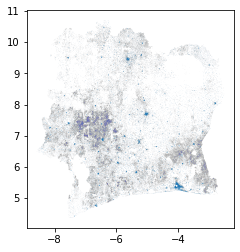

In [25]:
OCI.plot()

# Creation de la grid de la map

In [13]:
def createGridedMap(map_c, n_cells,print_map=False):
    
    xmin, ymin, xmax, ymax = map_c.total_bounds
    cell_size = (xmax-xmin)/n_cells
    crs = map_c.crs.srs
    grid_cells = []
    
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    map_cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                     crs=crs)
    map_cell["area_cell"] = map_cell["geometry"].area
    
    if print_map:
        map_cell.plot( facecolor="none", edgecolor='grey')
        
    return map_cell

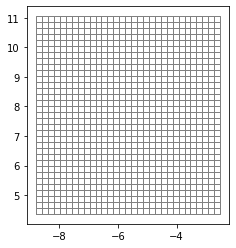

In [14]:
OCI_cell = createGridedMap(OCI,30,print_map=True)

# Creation de la map discretisee

In [15]:
def popCellCreation(map_c, map_cell):
    map_cc = map_c.copy()
    map_cc["savedSettlementsGeometry"] = map_cc.geometry
    map_cell_agg = gpd.sjoin(map_cell, map_cc, how="left")
    map_cell_agg["IntersectArea"] = map_cell_agg["geometry"].intersection(map_cell_agg["savedSettlementsGeometry"])
    map_cell_agg["IntersectArea_area"] = map_cell_agg["IntersectArea"].area
    map_cell_agg["pop_cell_intersect"] = map_cell_agg["population"] * (map_cell_agg["IntersectArea_area"]/map_cell_agg["area_settlement"])
    map_cell_agg_gb = map_cell_agg.groupby(map_cell_agg.index)['pop_cell_intersect'].sum()
    map_cell["pop_tot"]=map_cell_agg_gb
    return map_cell

In [16]:
OCI_cell = popCellCreation(OCI, OCI_cell)

<AxesSubplot:>

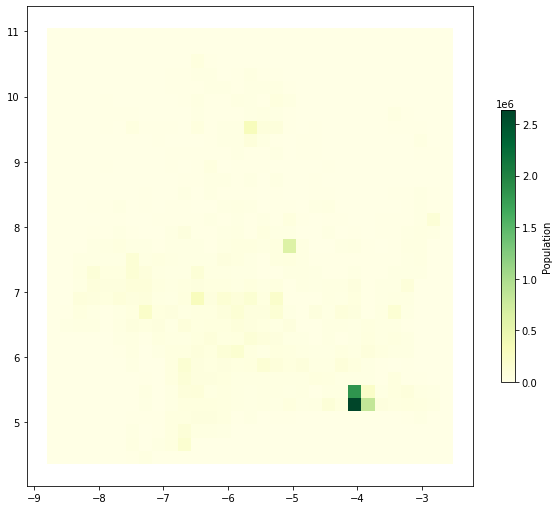

In [17]:
OCI_cell.plot(column='pop_tot', cmap="YlGn", legend=True, legend_kwds={'label': "Population", 'shrink': 0.5}, figsize=(10,10))

In [18]:
# On vérifie que la discretisation donne bien la même population à la fin
OCI_cell["pop_tot"].sum()

26547263.206248403

# Utilisation Contour Cote d'Ivoire

In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

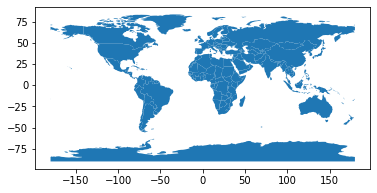

In [20]:
world.plot()

In [21]:
CoteIvoire = world[world.name=="Côte d'Ivoire"]

<AxesSubplot:>

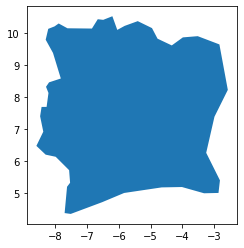

In [22]:
CoteIvoire.plot()

<AxesSubplot:>

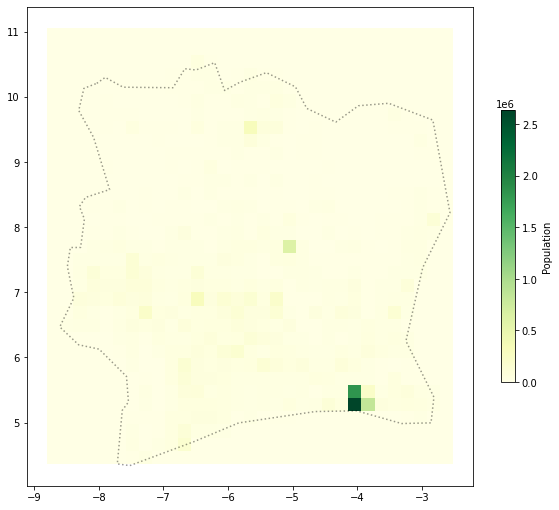

In [23]:
ax = OCI_cell.plot(column='pop_tot', cmap="YlGn", legend=True, legend_kwds={'label': "Population", 'shrink': 0.5}, figsize=(10,10))
plt.autoscale(False)
CoteIvoire.boundary.plot(ax=ax,figsize=(10,10), color=None, alpha = 0.4, linestyle=':', edgecolor='black')

# Import Carte CI donnée par OCI

In [2]:
map_oci = r"C:\Users\SJJL8654\Documents\SMARTCAPEX\Data\cote_d_ivoire\Cote_d_ivoire.shp"

In [3]:
map_CI = gpd.read_file(map_oci)

In [6]:
map_CI.head(2)

,ID_REGION,REGION,geometry
0,1,DISTRICT AUTONOME D'ABIDJAN,"POLYGON ((-4.25351 5.60266, -4.22936 5.59690, ..."
1,2,DISTRICT AUTONOME DE YAMOUSSOUKRO,"POLYGON ((-5.23912 7.08899, -5.23720 7.08877, ..."


<AxesSubplot:>

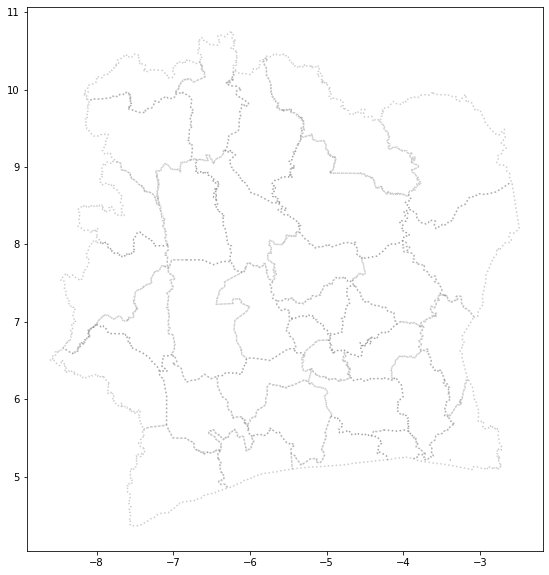

In [9]:
map_CI.boundary.plot(figsize=(10,10), color=None, alpha = 0.2, linestyle=':', edgecolor='black')

# Densite population

In [11]:
path_map_denspop = r"C:\Users\SJJL8654\Documents\SMARTCAPEX\Data\2--Data_Sources\Id_18_Density Pop Coverage\Desnsité Pop\Densite_Population_f.shp"

In [13]:
map_dens_pop = gpd.read_file(path_map_denspop)

In [14]:
map_dens_pop.head(2)

,OBJECTID,FID_Popula,id_unique,type_zone,id_geoloc,ville_geol,id_ua,ua,departeme,region,district,pop_2015,aire_m2,Shape_Leng,geometry
0,527562,155835,281054,RURAL,3398,MINIGNAN,238,MINIGNAN,MINIGNAN,FOLON,DENGUELE,7.034266,847385.941053,123.056295,"POLYGON ((-31238.842 1108250.000, -31250.000 1..."
1,527563,301548,281055,RURAL,3398,MINIGNAN,238,MINIGNAN,MINIGNAN,FOLON,DENGUELE,53.259446,847171.654100,276.954495,"POLYGON ((-31150.000 1108250.000, -31238.842 1..."


<AxesSubplot:>

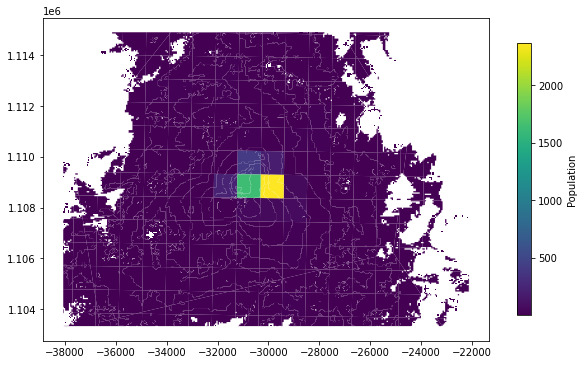

In [20]:
map_dens_pop.plot(figsize=(10,10), column='pop_2015', color=None, legend=True, legend_kwds={'label': "Population", 'shrink': 0.5})

# Coverage

In [21]:
path_map_coverage = r"C:\Users\SJJL8654\Documents\SMARTCAPEX\Data\2--Data_Sources\Id_19_Coverage\Coverage.shp"

In [22]:
map_coverage = gpd.read_file(path_map_coverage)

In [29]:
map_coverage.head(2)

,Float,String,geometry
0,-55.0,None,"MULTIPOLYGON (((-30650.000 1109600.000, -30600..."
1,-50.0,None,"MULTIPOLYGON (((-31300.000 1108850.000, -31250..."


<AxesSubplot:>

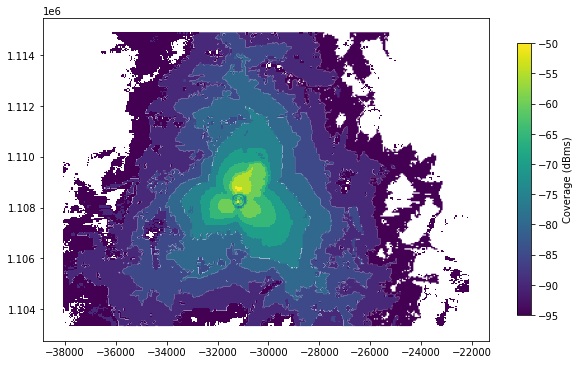

In [28]:
map_coverage.plot(figsize=(10,10), column='Float', color=None, legend=True, legend_kwds={'label': "Coverage (dBms)", 'shrink': 0.5})